In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import vireoSNP
from utilities import *
import re

## Read data

In [2]:
## read p-value data
folder_path = "/home/linxy29/data/maester/maester_paper/bpdcn712/variant_selection/version2/"
res_name = "bpdcn712_assemble_trimmed_aligned_mt_addtag_cellSNP0"
res = pd.read_csv(folder_path + res_name + "_fixedeffect_1vsall_res.csv", index_col=0)
print("The dimension of the p-value data is: ", res.shape)
## convert index to column
res = res.reset_index()
print(res.head())

The dimension of the p-value data is:  (270892, 5)
   Wald_pval    LR_val  LRT_pval  LRT_fdr         group variant
0   0.543613 -0.209564  1.000000      1.0  CASSPFEETQYF  682A>T
1   0.986454  9.785323  0.007501      1.0  CASSPFEETQYF  683G>A
2   0.589681  0.276840  0.870733      1.0  CASSPFEETQYF  684T>A
3   0.876587  0.191265  0.908798      1.0  CASSPFEETQYF  685A>C
4   0.549131  0.340161  0.843597      1.0  CASSPFEETQYF  686A>C


In [3]:
## read variant data
bpdcn712_mquad, bpdcn712_barcode = load_cellsnp("/home/linxy29/data/maester/maester_paper/bpdcn712/maester/" + res_name + "/")
print("The dimension of the AD data is: ", bpdcn712_mquad.ad.shape)
print("The dimension of the DP data is: ", bpdcn712_mquad.dp.shape)
print("The number of mtSNPs is: ", len(bpdcn712_mquad.variants))

Loaded VCF file: /home/linxy29/data/maester/maester_paper/bpdcn712/maester/bpdcn712_assemble_trimmed_aligned_mt_addtag_cellSNP0/cellSNP.cells.vcf.gz
16569 variants detected
variant names detected
The dimension of the AD data is:  (16569, 11803)
The dimension of the DP data is:  (16569, 11803)
The number of mtSNPs is:  16569


In [4]:
# Read paper variants
paper_variant_file = '/home/linxy29/data/maester/maester_paper/bpdcn712/variant_selection/version2/paper_variant.txt'

# Read the paper variants into a set for efficient lookups
with open(paper_variant_file, 'r') as file:
    paper_variants = set(file.read().splitlines())

print("The first 10 paper variants are: ", list(paper_variants)[:10])
print("The number of paper variants is: ", len(paper_variants))

The first 10 paper variants are:  ['3628A>G', '9753G>A', '1222A>G', '10158T>A', '9164T>C', '1415G>A', '15812G>A', '6185T>C', '6293T>C', '1171A>G']
The number of paper variants is:  16


In [5]:
res['group'].unique()

array(['CASSPFEETQYF', 'CASSFRQGYNEQFF', 'CASSQAGAANTEAFF',
       'CASSATRAETQYF', 'CASSQVGHSADTQYF', 'CATPGSLNYGYTF',
       'CASSLVEEKLFF', 'CASSLGGTVSYEQYF', 'CASSLTGGSYNEQFF',
       'CASAPNFGQELTYEQYF', 'CASSQFPAPGPGEAQHF', 'CASRRGSSEQFF',
       'CASSLTSGDPTDTQYF', 'CASIPGPGTSGYNEQFF', 'CASSLVSGEVNEKLFF',
       'CASSSRDRGGLVPGELFF', 'CASSPGFGKLFF', 'CASSRYRGGTEAFF',
       'CASSFRLATDTQYF', 'CASSLEWGNPSTYEQYF', 'CASSLYWTDTQYF',
       'CASSPGGNEQFF', 'CASSYRLPGPGELFF', 'CSANPGQGVDEQYF',
       'CASSYPLWGGARQPQHF', 'CSARDIHTYNEQFF', 'CATSGGWGGETQYF',
       'CASSLAWGAYEQYF', 'CSVEDLGMDSPSYNEQFF', 'CASSLGWTENTGELFF',
       'CASGILGTQYF', 'CSVGTGGTNEKLFF'], dtype=object)

In [6]:
# clone shown in the paper
paper_clone = ['CASSLVEEKLFF', 'CASSFRQGYNEQFF', 'CASSLTGGSYNEQFF', 'CASSRYRGGTEAFF', 'CASSPFEETQYF', 'CSVEDLGMDSPSYNEQFF', 'CATSGGWGGETQYF', 'CASSQAGAANTEAFF', 'CASSQVGHSADTQYF', 'CASSLTSGDPTDTQYF']
# Read clone ID
clonID = pd.read_csv("/home/linxy29/data/maester/maester_paper/bpdcn712/bpdcn_clone.csv")
# filter out rows with missing value in TRB_CDR3
clonID = clonID[clonID['TRB_CDR3'].notnull()]
# remove -1 in the barcode column
clonID["barcode"] = clonID["barcode"].str.replace('-1$', '', regex=True)
print("The dimension of the clone ID data is: ", clonID.shape)
print(clonID.head())

The dimension of the clone ID data is:  (3326, 4)
              barcode         TRB_CDR3          TRA_CDR3  MT_clone
19   CCTAACCGTTCTAACG     CASSPFEETQYF  CAVIPH*NSGYSTLTF  2593_G>A
34   ATCCGTCCAAGAGTTA   CASSFRQGYNEQFF     CAYRRNNNNDMRF   683_G>A
88   ACTATCTCAGCACGAA  CASSQAGAANTEAFF     CAVNATNKLIFGT       NaN
212  TAGATCGAGGATTACA  CASSQAGAANTEAFF               NaN       NaN
296  ACTGTGACACGATAGG  CASSQAGAANTEAFF               NaN  1323_G>A


## Plot
We can plot 1) p-values and allele frequencies of variants defined in the original paper; Plot 2) Description of p-values; Plot 3) variants with low p-values

Let's start with plot 1.

In [7]:
## change the variant names to the format of the paper
bpdcn712_mquad.variants = [f"{parts[1]}{parts[2]}>{parts[3]}" for parts in (variant.split('_') for variant in bpdcn712_mquad.variants)]
print("The first 10 variants are: ", bpdcn712_mquad.variants[:10])

The first 10 variants are:  ['1G>A', '2A>C', '3T>A', '4C>A', '5A>C', '6C>A', '7A>C', '8G>A', '9G>A', '10T>A']


In [8]:
## check whether the mutation site are in the paper
paper_site = [int(re.match(r'\d+', item).group()) for item in paper_variants]
print("The first 10 mutation sites in paper are: ", paper_site[:10])
## extract the number in the variant name from the res data and create a new column
res["site"] = [int(re.match(r'\d+', item).group()) for item in res["variant"]]
print(res.head())
print("The dimension of the res data is: ", res.shape)

The first 10 mutation sites in paper are:  [3628, 9753, 1222, 10158, 9164, 1415, 15812, 6185, 6293, 1171]
   Wald_pval    LR_val  LRT_pval  LRT_fdr         group variant  site
0   0.543613 -0.209564  1.000000      1.0  CASSPFEETQYF  682A>T   682
1   0.986454  9.785323  0.007501      1.0  CASSPFEETQYF  683G>A   683
2   0.589681  0.276840  0.870733      1.0  CASSPFEETQYF  684T>A   684
3   0.876587  0.191265  0.908798      1.0  CASSPFEETQYF  685A>C   685
4   0.549131  0.340161  0.843597      1.0  CASSPFEETQYF  686A>C   686
The dimension of the res data is:  (270892, 7)


In [9]:
## get the p-value of the paper site
## extract the row with site in paper site
paper_pval = res[res["site"].isin(paper_site)]
print("The dimension of the paper p-value data is: ", paper_pval.shape)
print(paper_pval)

The dimension of the paper p-value data is:  (428, 7)
        Wald_pval    LR_val  LRT_pval  LRT_fdr           group   variant  \
1        0.986454  9.785323  0.007501      1.0    CASSPFEETQYF    683G>A   
483      0.997744  0.820321  0.663544      1.0    CASSPFEETQYF   1171A>G   
532      0.981734  0.000495  0.999752      1.0    CASSPFEETQYF   1222A>T   
633      0.543233  0.369357  0.831371      1.0    CASSPFEETQYF   1323G>T   
1684     0.030209  3.700214  0.157220      1.0    CASSPFEETQYF   2593G>A   
...           ...       ...       ...      ...             ...       ...   
267979   0.077325  3.148920  0.207119      1.0  CSVGTGGTNEKLFF   9164T>G   
268542   0.349206 -0.204669  1.000000      1.0  CSVGTGGTNEKLFF   9753G>T   
268786   0.991321  0.735722  0.692213      1.0  CSVGTGGTNEKLFF  10158T>A   
270303   0.559085  0.276249  0.870990      1.0  CSVGTGGTNEKLFF  15299T>G   
270816   0.993647  0.000119  0.999940      1.0  CSVGTGGTNEKLFF  15812G>T   

         site  
1         683  
4

In [10]:
## plot heatmap using group as x-axis and vairant as y-axis, # Pivot the DataFrame to prepare for heatmap plotting
heatmap_data = paper_pval.pivot("variant", "group", "Wald_pval")
## filter the data with p-value < 0.05
heatmap_data = heatmap_data[heatmap_data < 0.1]
print("The dimension of the heatmap data is: ", heatmap_data.shape)
print(heatmap_data.head())

The dimension of the heatmap data is:  (14, 32)
group     CASAPNFGQELTYEQYF  CASGILGTQYF  CASIPGPGTSGYNEQFF  CASRRGSSEQFF  \
variant                                                                     
10158T>A                NaN          NaN                NaN           NaN   
1171A>G                 NaN     0.017790                NaN           NaN   
1222A>T                 NaN          NaN                NaN           NaN   
1323G>T                 NaN     0.081437                NaN           NaN   
15299T>G                NaN          NaN                NaN           NaN   

group     CASSATRAETQYF  CASSFRLATDTQYF  CASSFRQGYNEQFF  CASSLAWGAYEQYF  \
variant                                                                   
10158T>A            NaN             NaN             NaN             NaN   
1171A>G             NaN             NaN             NaN             NaN   
1222A>T             NaN             NaN             NaN             NaN   
1323G>T             NaN             N

In [11]:
row_number = 0
column_order = []
for row_number in range(heatmap_data.shape[0]):
    ## get the unordered column names
    unordered_column = [column for column in heatmap_data.columns.tolist() if column not in column_order]
    ## find the column with non-NA value in the row
    row_data = heatmap_data.loc[heatmap_data.index[row_number], unordered_column]
    # Filter out NaN values and sort the non-NA values
    sorted_row_data = row_data.dropna().sort_values()
    # Extract the column names of the non-NA values
    value_column = sorted_row_data.index.tolist()
    column_order.extend(value_column)
print("The column order is: ", column_order)
print("The number of column order is: ", len(column_order))

The column order is:  ['CASSRYRGGTEAFF', 'CASSPGGNEQFF', 'CASGILGTQYF', 'CASSPGFGKLFF', 'CASSLTGGSYNEQFF', 'CATPGSLNYGYTF', 'CASSLVEEKLFF', 'CASSLEWGNPSTYEQYF', 'CASSSRDRGGLVPGELFF', 'CASSLVSGEVNEKLFF', 'CSANPGQGVDEQYF', 'CSVEDLGMDSPSYNEQFF', 'CASRRGSSEQFF', 'CASSQAGAANTEAFF', 'CASSPFEETQYF', 'CASSYPLWGGARQPQHF', 'CASSFRLATDTQYF', 'CASSFRQGYNEQFF', 'CASSQVGHSADTQYF', 'CASSLGGTVSYEQYF', 'CASSQFPAPGPGEAQHF', 'CASAPNFGQELTYEQYF', 'CSVGTGGTNEKLFF']
The number of column order is:  23


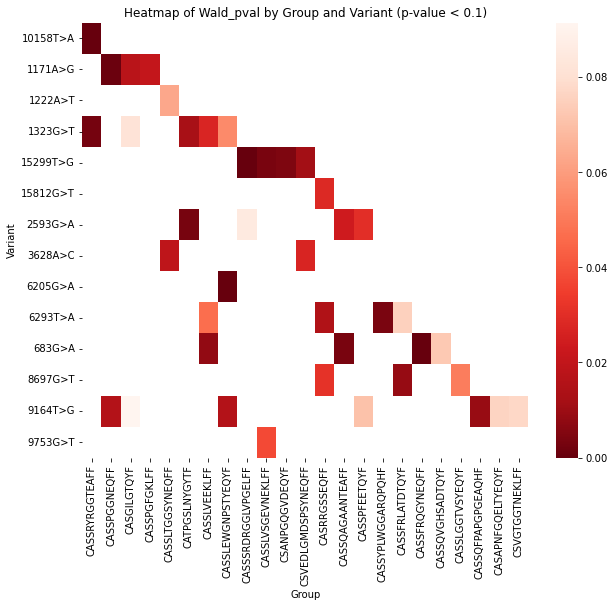

In [12]:
# Plotting the heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size to fit your needs
sns.heatmap(heatmap_data.loc[:,column_order], cmap='Reds_r')  # `annot=True` to annotate cells with Wald_pval values
plt.title('Heatmap of Wald_pval by Group and Variant (p-value < 0.1)')
plt.xlabel('Group')
plt.ylabel('Variant')
plt.show()

In [13]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

raw_col = cm.get_cmap('Reds_r', 200)
new_col = np.vstack((raw_col(np.linspace(0, 0.1, 10)),
                     raw_col(np.linspace(0.1, 1, 90))))
segred = ListedColormap(new_col, name='segred')

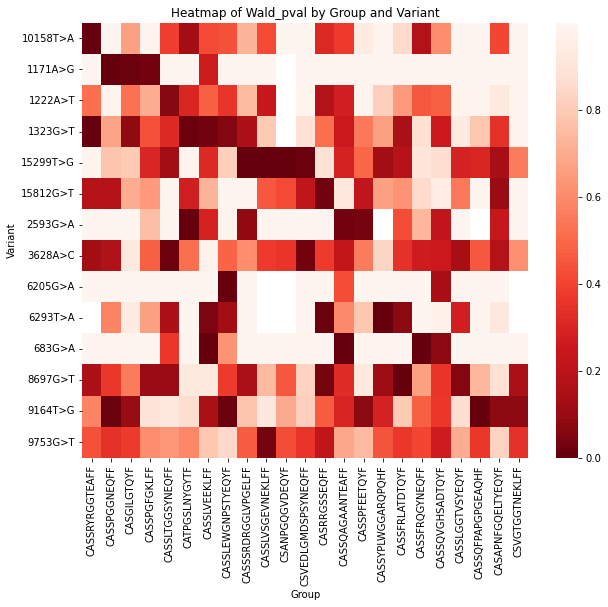

In [14]:
heatmap_data = paper_pval.pivot("variant", "group", "Wald_pval")
# Plotting the heatmap
plt.figure(figsize=(10, 8))  # You can adjust the size to fit your needs
sns.heatmap(heatmap_data.loc[:,column_order], cmap=segred)  # `annot=True` to annotate cells with Wald_pval values
plt.title('Heatmap of Wald_pval by Group and Variant')
plt.xlabel('Group')
plt.ylabel('Variant')
plt.show()

In [15]:
## get indices in mquad data
mquad_site = [int(re.match(r'\d+', item).group()) for item in bpdcn712_mquad.variants]
print("The first 10 data sites are: ", mquad_site[:10])
## get the index of the paper site in the mquad site
paper_mquad_index = [mquad_site.index(item) for item in paper_site]
print("The first 10 paper index are: ", paper_mquad_index[:10])
## subset clone that are shown in the paper
subset_clonID = clonID[clonID["TRB_CDR3"].isin(paper_clone)]
## get the cell index that have cell line information
include_cell_index = [index for index in range(len(bpdcn712_barcode)) if bpdcn712_barcode[index] in subset_clonID['barcode'].values]
include_cell_barcode = [bpdcn712_barcode[index] for index in include_cell_index]
print("The number of cell line cells are: ", len(include_cell_index))

The first 10 data sites are:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
The first 10 paper index are:  [3627, 9752, 1221, 10157, 9163, 1414, 15811, 6184, 6292, 1170]
The number of cell line cells are:  2237


In [17]:
true_variants_mquad, true_variants_barcode = select_mquad(bpdcn712_mquad, bpdcn712_barcode, include_indices= paper_mquad_index, include_cell=include_cell_index)
print("The dimension of the AD data is: ", true_variants_mquad.ad.shape)
print("The dimension of the DP data is: ", true_variants_mquad.dp.shape)
print("The number of mtSNPs is: ", len(true_variants_mquad.variants))

The dimension of the AD data is:  (16, 2237)
The dimension of the DP data is:  (16, 2237)
The number of mtSNPs is:  16


In [18]:
## save mquad data
write_mquad(true_variants_mquad, true_variants_barcode, "/home/linxy29/data/maester/maester_paper/bpdcn712/maester/bpdcn712_assemble_trimmed_aligned_mt_addtag_cellSNP0_paperVariantCell")
subsetCell_mquad, subsetCell_barcode = select_mquad(bpdcn712_mquad, bpdcn712_barcode, include_cell=include_cell_index)
write_mquad(subsetCell_mquad, subsetCell_barcode, "/home/linxy29/data/maester/maester_paper/bpdcn712/maester/bpdcn712_assemble_trimmed_aligned_mt_addtag_cellSNP0_paperCell")
print("The dimension of the AD data is: ", subsetCell_mquad.ad.shape)
print("The dimension of the DP data is: ", subsetCell_mquad.dp.shape)
print("The number of mtSNPs is: ", len(subsetCell_mquad.variants))

The dimension of the AD data is:  (16569, 2237)
The dimension of the DP data is:  (16569, 2237)
The number of mtSNPs is:  16569


In [19]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

raw_col = cm.get_cmap('pink_r', 200)
new_colors = raw_col(np.linspace(0, 1, 256))
even_seg_pink = LinearSegmentedColormap.from_list("even_seg_pink", new_colors)
new_col = np.vstack((raw_col(np.linspace(0, 0.7, 10)),
                     raw_col(np.linspace(0.7, 1, 90))))
segpink = ListedColormap(new_col, name='segpink')

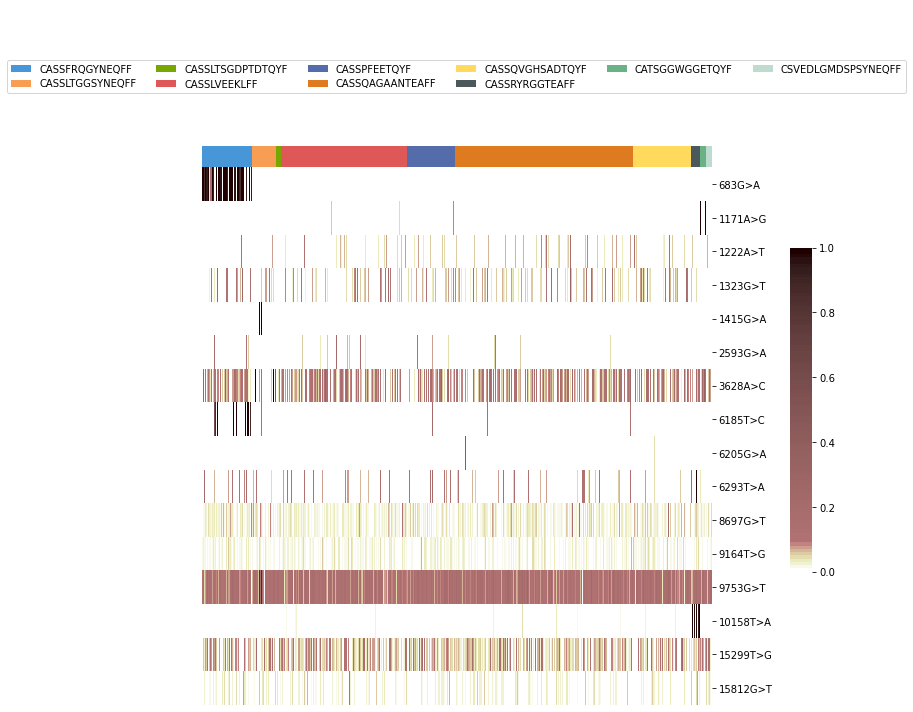

In [20]:
data_array = np.divide(true_variants_mquad.ad, true_variants_mquad.dp, where=(true_variants_mquad.dp != 0))
data_array = np.nan_to_num(data_array)
mtSNP_ids = true_variants_mquad.variants
cell_label = [clonID[clonID['barcode'] == barcode]['TRB_CDR3'].values[0] for barcode in include_cell_barcode]
id_uniq = np.unique(cell_label)
# add a new color
vireoSNP.plot.base_plot.vireo_colors = np.array(['#4796d7', '#f79e54', '#79a702', '#df5858', '#556cab', 
                         '#de7a1f', '#ffda5c', '#4b595c', '#6ab186', '#bddbcf', 
                         '#daad58', '#488a99', '#f79b78', '#ffba00', '#720117', '#ffeed0', '#0a465d', 
                         '#f6b7c9', '#00e5e5', '#0073e5', '#7ddc1f', '#d5e711', '#e9f204', '#7f6966'])
vireoSNP.plot.anno_heat(data_array, col_anno=cell_label, col_order_ids=id_uniq,
                        cmap=segpink, yticklabels=mtSNP_ids)

In [21]:
print(len(id_uniq))

10


Plot 2) Description of p-values

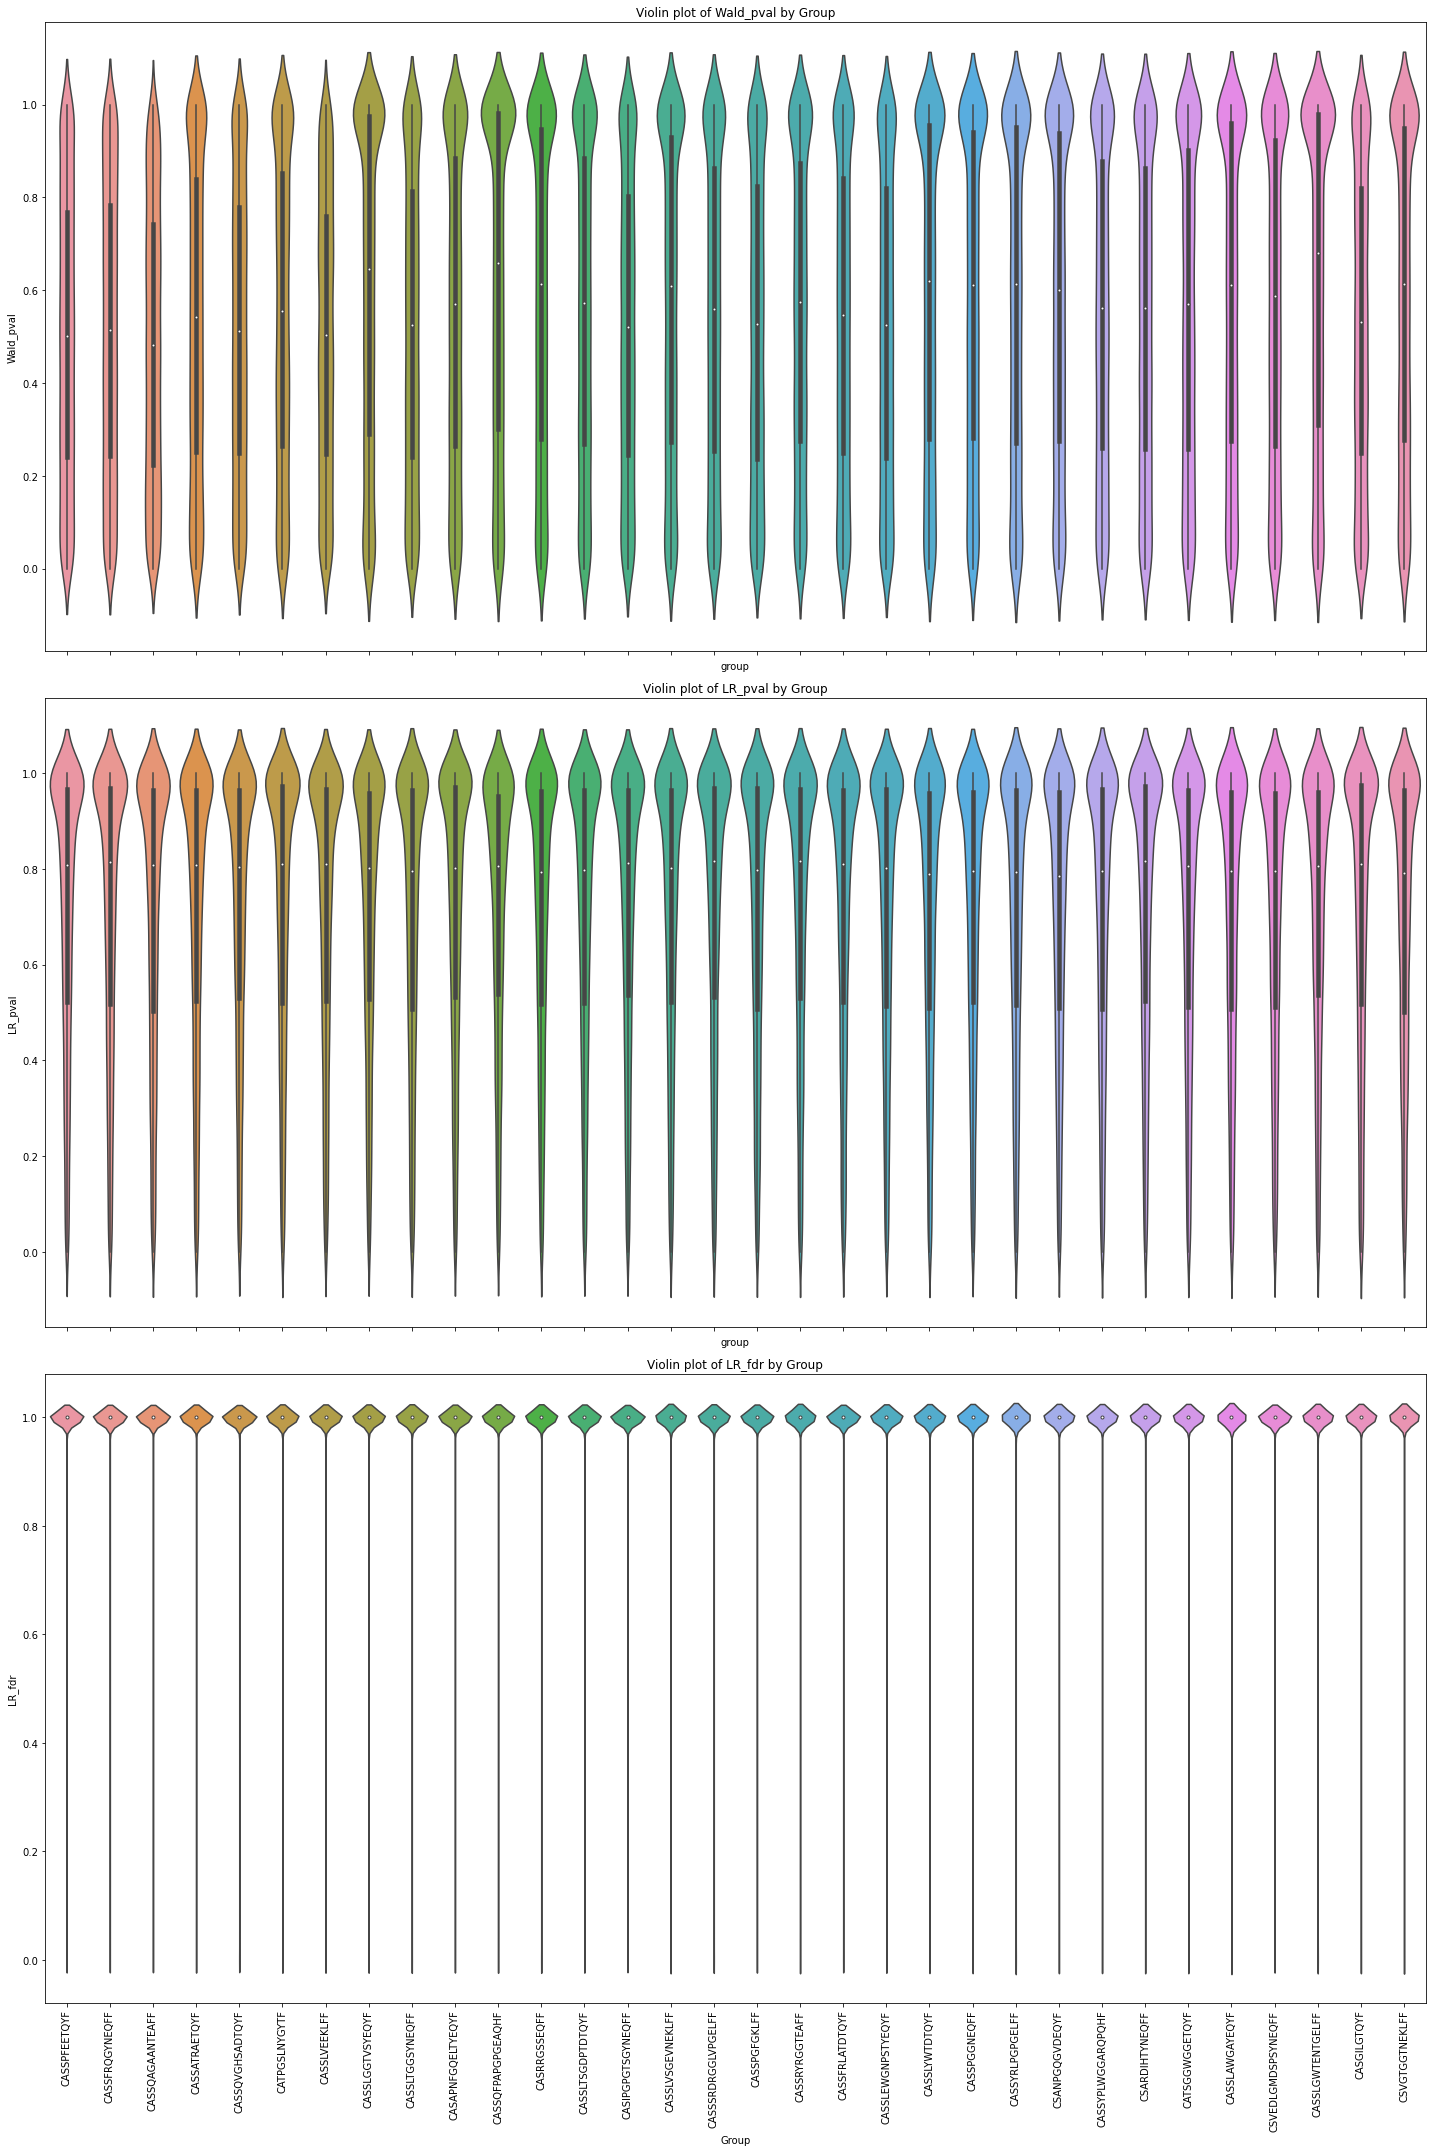

In [22]:
# Create a figure with four subplots
fig, axes = plt.subplots(3, 1, figsize=(20, 30))
# plot the distribution of wald p-value
sns.violinplot(x="group", y="Wald_pval", data=res, ax=axes[0])
axes[0].set_title('Violin plot of Wald_pval by Group')
#axes[0].set_xlabel('Group')
axes[0].set_ylabel('Wald_pval')
axes[0].set_xticklabels([])  # Clears the x-axis labels

# plot the distribution of likelihood ratio p-value
sns.violinplot(x="group", y="LRT_pval", data=res, ax=axes[1])
axes[1].set_title('Violin plot of LR_pval by Group')
#axes[1].set_xlabel('Group')
axes[1].set_ylabel('LR_pval')
axes[1].set_xticklabels([])  # Clears the x-axis labels

# plot the distribution of likelihood ratio false discovery rate
sns.violinplot(x="group", y="LRT_fdr", data=res, ax=axes[2])
axes[2].set_title('Violin plot of LR_fdr by Group')
axes[2].set_xlabel('Group')
axes[2].set_ylabel('LR_fdr')
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=90)  # Rotates the labels to be vertical

plt.tight_layout()  # Adjusts plot to ensure everything fits without overlap
plt.show()

In [31]:
## get the variants where LRTe p-value is less than 0.05
test = "LRT_pval"
sig_test_variant = res[res[test] < 0.05]['variant'].unique()
print("The first 10 significant sites by LRT test are: ", sig_test_variant[:10])
print("The number of significant sites by LRT test is: ", len(sig_test_variant))

The first 10 significant sites by LRT test are:  ['683G>A' '766G>T' '768A>T' '925T>A' '975A>C' '1034T>G' '1045G>T'
 '1104A>T' '1168A>T' '1263G>T']
The number of significant sites by LRT test is:  2740


In [32]:
sig_test_mquad_index = [bpdcn712_mquad.variants.index(item) for item in sig_test_variant]
sig_test_variants_mquad, sig_test_variants_barcode = select_mquad(bpdcn712_mquad, bpdcn712_barcode, include_indices= sig_test_mquad_index, include_cell=include_cell_index)
write_mquad(sig_test_variants_mquad, sig_test_variants_barcode, "/home/linxy29/data/maester/maester_paper/bpdcn712/maester/bpdcn712_assemble_trimmed_aligned_mt_addtag_cellSNP0_" + test.replace("_pval", "") + "Variant_paperCell")
print("The dimension of the AD data is: ", sig_test_variants_mquad.ad.shape)
print("The dimension of the DP data is: ", sig_test_variants_mquad.dp.shape)
print("The number of mtSNPs is: ", len(sig_test_variants_mquad.variants))

The dimension of the AD data is:  (2740, 2237)
The dimension of the DP data is:  (2740, 2237)
The number of mtSNPs is:  2740
